In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2

(<matplotlib.axes._subplots.AxesSubplot at 0x7ff3672db590>,
 (-0.5, 149.5, 249.5, -0.5))

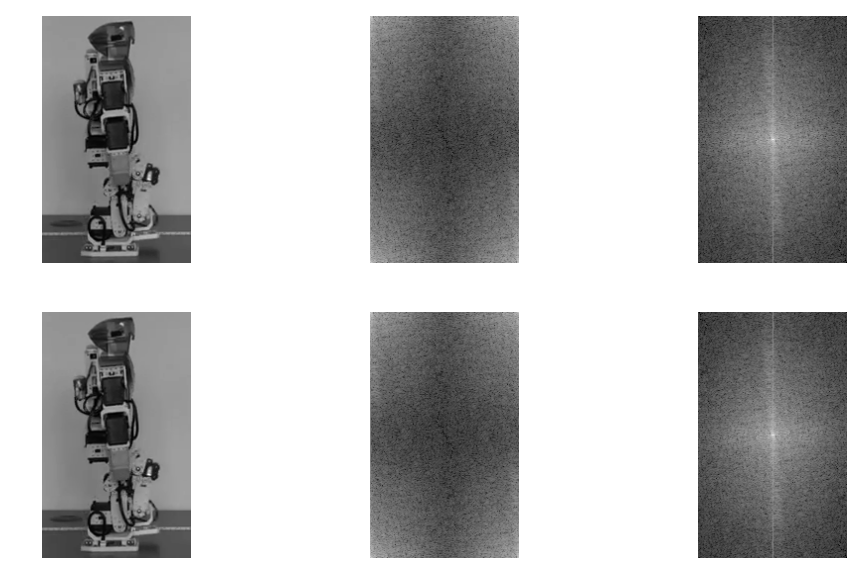

In [6]:
img = cv2.imread('data/biowalk-0300.png',0)
img_reduced = img[85:335, 150:300]

f = np.fft.fft2(np.float32(img_reduced))
fshift = np.fft.fftshift(f)
f = 20*np.log(np.abs(f))
fshift = 20*np.log(np.abs(fshift))

dft = cv2.dft(np.float32(img_reduced),flags = cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

#dft = cv2.magnitude(dft[:,:,0],dft[:,:,1])
#dft_shift = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])

dft = 20*np.log(cv2.magnitude(dft[:,:,0],dft[:,:,1]))
dft_shift = 20*np.log(cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1]))

plt.figure(figsize=(12,7))
plt.subplot(2,3,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,2),plt.imshow(f,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,3),plt.imshow(fshift,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,4),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,5),plt.imshow(dft,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,6),plt.imshow(dft_shift,cmap='gray',interpolation=None),plt.axis('off')


In [6]:
# filtros pasa-bajo
def filter_ideal_fcn(H,D,D0,params):
    H[D<=D0] = 1
    return H
def filter_butterworth_fcn(H,D,D0,params=2):
    n = params
    H[:] = 1/(1+np.power(D[:]/D0,2*n))
    return H
def filter_gaussian_fcn(H,D,D0,params=2):
    n = params
    H[:] = np.exp(-np.power(D[:]/D0,2)/(n))
    return H

def get_filter_for_image(rows,cols,D0,filter_fcn,params=0,off_rows = 0, off_cols = 0):
    H = np.zeros((rows,cols))
    D = np.zeros_like(H)
    u, v= np.arange(0,rows), np.arange(0,cols)
    U = u[:rows].reshape((rows,1))*np.ones((1,cols))
    V = np.ones((rows,1))*v[:cols].reshape((1,cols))
    D = np.sqrt(np.power(U-rows/2-off_rows,2)+np.power(V-cols/2-off_cols,2))
    H = filter_fcn(H,D,D0,params)
    return H 

def get_notch_filter(rows,cols,D0,filter_fcn,params,u,v):
    H1 = get_filter_for_image(rows,cols,D0,filter_fcn,params,off_rows=u,off_cols=v)
    if u==0 and v==0:
        return H1
    H2 = get_filter_for_image(rows,cols,D0,filter_fcn,params,off_rows=-u,off_cols=-v)
    return H1+H2

def make_spectrum(img):
    f_im = np.fft.fft2(img)
    f_im_shift = np.fft.fftshift(f_im)
    mag_spect = 20*np.log(np.abs(f_im_shift))    
    return mag_spect

def apply_frecuency_filter_to_image(img, H):
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    f_ishift = np.fft.ifftshift(fshift*H)
    img_back = np.fft.ifft2(f_ishift)
    img_back = np.abs(img_back)
    return img_back


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcc66c1e50>,
 (-0.5, 149.5, 249.5, -0.5))

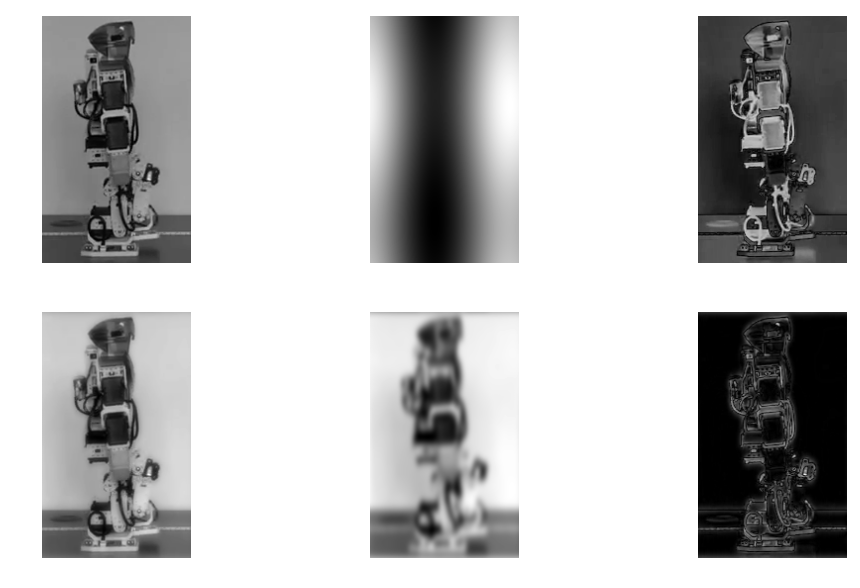

In [9]:
img_reduced = img[85:335, 150:300]
# img_reduced = cv2.medianBlur(img_reduced,5)

# filter_fcn = filter_ideal_fcn
# filter_fcn = filter_butterworth_fcn
filter_fcn = filter_gaussian_fcn
rows,cols = img_reduced.shape
H_L = get_filter_for_image(rows,cols,0.5,filter_fcn,params=2.0)
img_low_L = apply_frecuency_filter_to_image(img_reduced,H_L)
img_high_L = apply_frecuency_filter_to_image(img_reduced,1-H_L)
H_H = get_filter_for_image(rows,cols,10,filter_fcn,params=2.0)
img_low_H = apply_frecuency_filter_to_image(img_reduced,H_H)
img_high_H = apply_frecuency_filter_to_image(img_reduced,1-H_H)

plt.figure(figsize=(12,7))
plt.subplot(2,3,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,2),plt.imshow(img_low_L,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,3),plt.imshow(img_high_L,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,4),plt.imshow(img_reduced+img_low_H,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,5),plt.imshow(img_low_H,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(2,3,6),plt.imshow(img_high_H,cmap='gray',interpolation=None),plt.axis('off')


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcbc7d9650>,
 (-0.5, 149.5, 249.5, -0.5))

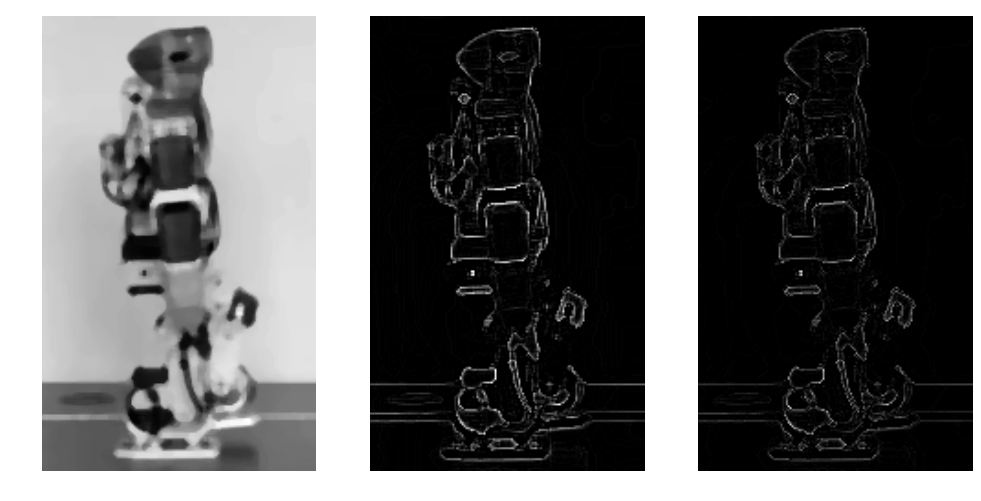

In [58]:
img_reduced = img[85:335, 150:300]
img_reduced = cv2.medianBlur(img_reduced,5)

#k = np.array([[0,1,0],[1,-4,1],[0,1,0]])
k = np.array([[1,1,1],[1,-8,1],[1,1,1]])
#k = np.array([[0,0,0],[0,1,0],[0,0,0]])-1.2*np.array([[1,1,1],[1,-8,1],[1,1,1]])
lap_kernel = cv2.filter2D(img_reduced,-1,k)
laplacian = cv2.Laplacian(img_reduced,cv2.CV_8U)

plt.figure(figsize=(12,7))
plt.subplot(1,3,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,3,2),plt.imshow(lap_kernel,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,3,3),plt.imshow(laplacian,cmap='gray',interpolation=None),plt.axis('off')


(-319.0, 212.0)


(<matplotlib.axes._subplots.AxesSubplot at 0x7ff365ef8990>,
 (-0.5, 149.5, 249.5, -0.5))

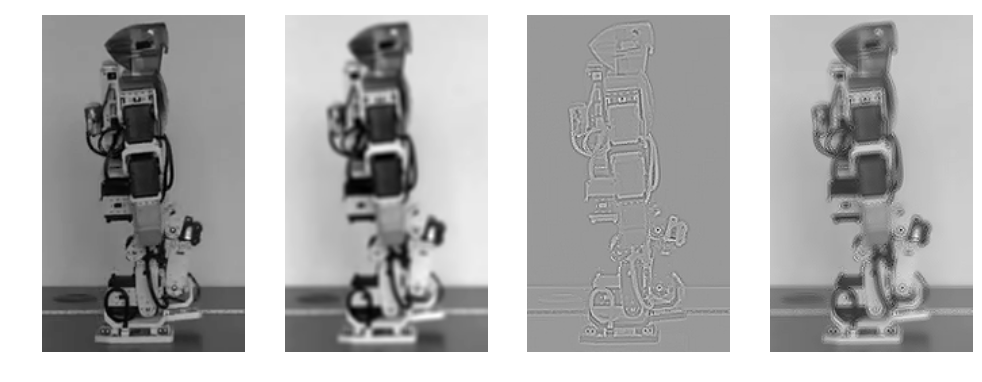

In [15]:
# sharpening
img_reduced = img[85:335, 150:300]
img_reduced = np.float32(img_reduced)

# 1. bluer original image
# blr_img = cv2.blur(img_reduced,(5,5))
# blr_img = cv2.medianBlur(img_reduced,5)
blr_img = cv2.GaussianBlur(img_reduced,(5,5),2.0)

# 2. 
# mask = img_reduced - blr_img
mask = cv2.Laplacian(img_reduced,cv2.CV_32F)
#mask = np.uint8(((mask-np.min(mask))*255)/(np.max(mask)-np.min(mask)))
#res,mask = cv2.threshold(mask,140,255,cv2.THRESH_BINARY_INV)
print(np.min(mask),np.max(mask))
# mask = img_high_H

# 3. add mask to original
enh_img = 0.75*img_reduced + 0.5*mask
enh_img = np.uint8(((enh_img-np.min(enh_img))*255)/(np.max(enh_img)-np.min(enh_img)))

plt.figure(figsize=(12,7))
plt.subplot(1,4,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,2),plt.imshow(blr_img,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,3),plt.imshow(mask,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,4),plt.imshow(enh_img,cmap='gray',interpolation=None),plt.axis('off')


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcbc34e2d0>,
 (-0.5, 149.5, 249.5, -0.5))

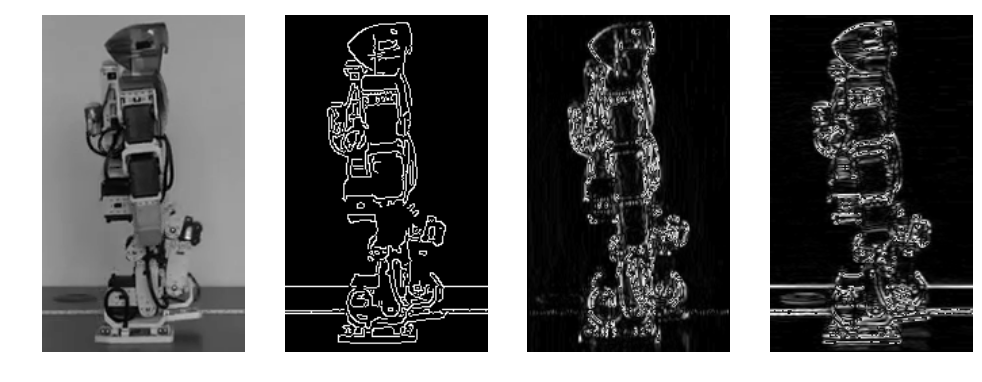

In [61]:
img_reduced = img[85:335, 150:300]
#img_reduced = cv2.equalizeHist(img_reduced)
#img_reduced = cv2.adaptiveThreshold(img_reduced,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
#                                    cv2.THRESH_BINARY,11,2)


img_canny_1 = cv2.Canny(img_reduced,100,200)
sobelx = np.uint8(np.absolute(cv2.Sobel(img_reduced,cv2.CV_64F,1,0,ksize=3)))
sobely = np.uint8(np.absolute(cv2.Sobel(img_reduced,cv2.CV_64F,0,1,ksize=3)))

plt.figure(figsize=(12,7))
plt.subplot(1,4,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,2),plt.imshow(img_canny_1,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,3),plt.imshow(sobelx,cmap='gray',interpolation=None),plt.axis('off')
plt.subplot(1,4,4),plt.imshow(sobely,cmap='gray',interpolation=None),plt.axis('off')


(<matplotlib.axes._subplots.AxesSubplot at 0x7fbcb832ed50>,
 (-0.5, 149.5, 249.5, -0.5))

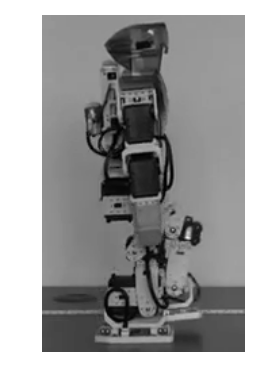

In [106]:
img_reduced = img[85:335, 150:300]

img_lapacian = cv2.Laplacian()
plt.figure(figsize=(12,7))
plt.subplot(1,4,1),plt.imshow(img_reduced,cmap='gray',interpolation=None),plt.axis('off')
